# Imports

In [1]:
import os

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, classification_report,
                             silhouette_score)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Create Dataframe

In [2]:
def create_emotion_dataframe(data_path):
    """
    Creates a dataframe of file names, their corresponding emotion labels,
    and reads audio data while traversing the folders.

    Parameters:
        data_path (str): Path to the main directory containing emotion folders.

    Returns:
        pd.DataFrame: A DataFrame with three columns - 'filename', 'emotion', and 'audio_data'.
    """
    # List to store file information
    data = []

    # Walk through each folder in the data directory
    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)
        
        # Check if the folder_path is a directory
        if os.path.isdir(folder_path):
            # Extract the emotion name from the folder name
            emotion = folder.split('_')[-1].lower()

            # List all files in the folder
            for file in os.listdir(folder_path):
                if file.endswith(".wav"):  # Check if it's a .wav file
                    file_path = os.path.join(folder_path, file)
                    
                    try:
                        # Load the audio file and get its waveform and sample rate
                        audio_data, sr = librosa.load(file_path, sr=None)
                        
                        # Append filename, emotion, and audio waveform data to the list
                        data.append((file, emotion, audio_data, sr))
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

    # Create a DataFrame
    df = pd.DataFrame(data, columns=["filename", "emotion", "audio_data", "sr"])
    return df


In [3]:
data_path = "data"

original_df = create_emotion_dataframe(data_path)
original_df.head()

,filename,emotion,audio_data,sr
0,YAF_date_disgust.wav,disgust,"[9.1552734e-05, 0.00018310547, 9.1552734e-05, ...",24414
1,YAF_rag_disgust.wav,disgust,"[0.0, 0.00015258789, 0.0, 0.0, -3.0517578e-05,...",24414
2,YAF_raise_disgust.wav,disgust,"[6.1035156e-05, 0.0, 6.1035156e-05, 0.00024414...",24414
3,YAF_ditch_disgust.wav,disgust,"[0.00021362305, 0.00045776367, 0.00021362305, ...",24414
4,YAF_door_disgust.wav,disgust,"[-0.00024414062, -0.00039672852, -6.1035156e-0...",24414


In [4]:
# define number of unique emotions
n_emotions = original_df["emotion"].nunique()
n_emotions

7

# Data Preprocessing

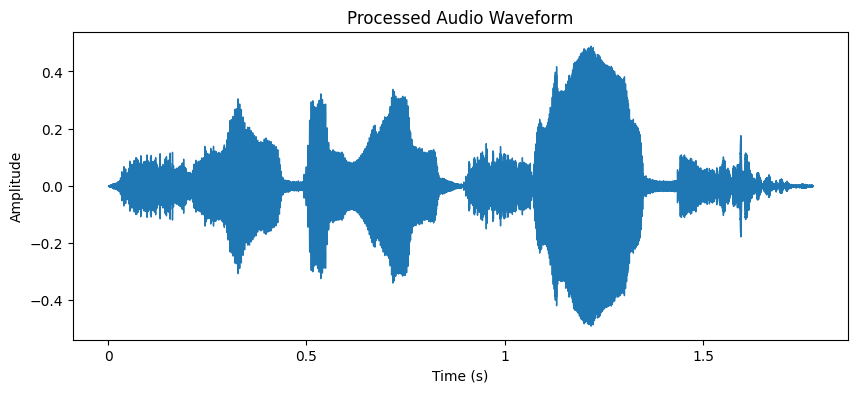

In [5]:
def preprocess_audio(df, file_path, target_sr=22050, duration=3.0):
    """
    Perform basic pre-processing of a .wav audio file.

    Parameters:
        file_path (str): Path to the .wav audio file.
        target_sr (int): Target sample rate for resampling (default is 22050 Hz).
        duration (float): Desired duration (in seconds) to pad/truncate the audio to.

    Returns:
        y (np.ndarray): Processed audio signal.
        sr (int): Sample rate.
    """
    try:
        # 1. Load the audio file
        y, sr = df["audio_data"][0], df["sr"][0]  # Resample to target_sr

        # 2. Pad or truncate to the desired duration
        max_length = int(target_sr * duration)  # Length in samples for the desired duration
        if len(y) < max_length:
            # Pad with zeros if shorter
            y = np.pad(y, (0, max_length - len(y)), mode='constant')
        else:
            # Truncate if longer
            y = y[:max_length]

        # 3. Remove leading and trailing silence (trim)
        y_trimmed, _ = librosa.effects.trim(y, top_db=30)

        # Optional: Replace with padded/truncated silence removal result
        if len(y_trimmed) < max_length:
            y = np.pad(y_trimmed, (0, max_length - len(y_trimmed)), mode='constant')
        else:
            y = y_trimmed[:max_length]

        print(f"Processed: {file_path} - Length: {len(y)} samples")
        return y, sr

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

y, sr = original_df["audio_data"][1999], original_df["sr"][0]

# Visualize the processed waveform
if y is not None:
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title("Processed Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

# Prosodic Features

### Extract Pitch Feature

Non-NaN F0 values: [273.20805135 251.98420998 270.06998923 282.84271247 296.21951046
 263.90158215 241.99881784 241.99881784 241.99881784 239.21922435
 236.47155721 236.47155721 235.10958126 196.56411971 239.21922435
 247.65527208 247.65527208 250.53288772 262.38162089 268.51450056
 270.06998923 277.98364397 284.48120364 286.12918649 287.786716
 289.45384749 292.81713919 299.66141538 273.20805135 274.79072949
 259.36791093 221.91389441 221.91389441 174.11011266 173.1073122
 172.11028745 172.11028745 174.11011266 176.13317472 178.17974363
 180.25009252 185.53182339 195.43199369 202.32388806 148.10975523
 157.82582947 190.96832078 194.30638823 192.07458901 183.40080864
 182.34449771]
Mean: 231.2945875696079
Std: 43.60024769967775
Min: 148.1097552286564
Max: 299.66141537533633


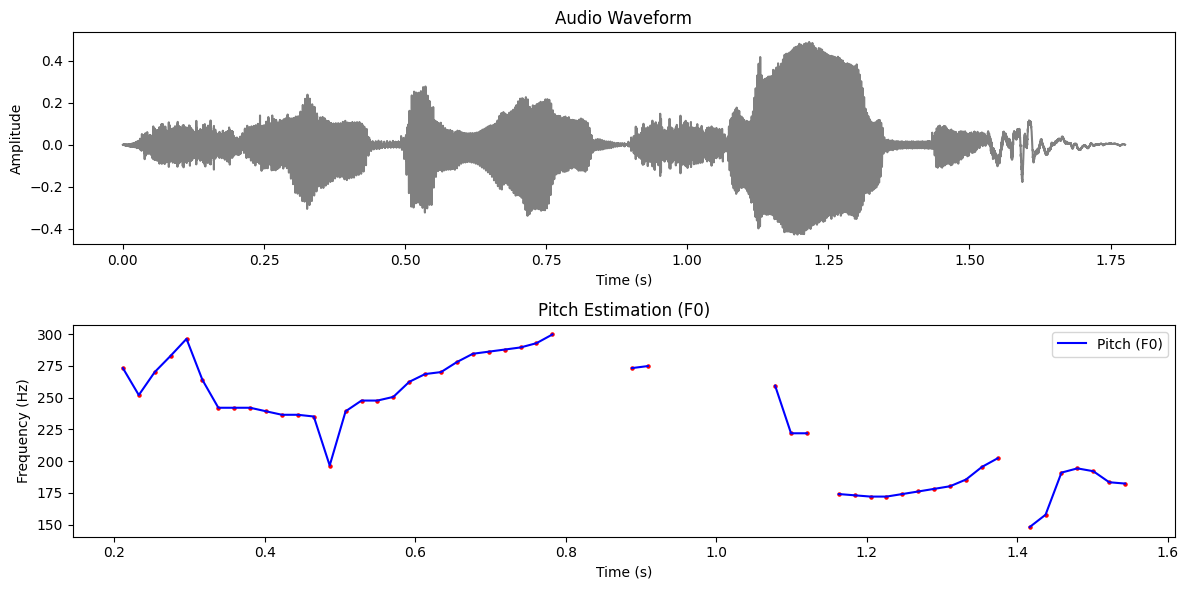

In [6]:
def extractNplot_pitch(audio_file):
    """
    Extracts and visualizes the pitch (F0) of the audio signal.

    The function estimates the fundamental frequency (F0) using `librosa.pyin`. 
    It computes basic statistics (mean, standard deviation, min, and max) for the 
    cleaned pitch values (non-NaN). Additionally, it plots both the audio waveform 
    and the estimated pitch over time.

    Args:
        audio_file (str): Path to the audio file.

    Returns:
        None: This function does not return any values but visualizes the results 
        and prints the computed statistics.
    """
    # Estimate the pitch (F0)
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=50, fmax=300, sr=sr)

    # Remove NaN values (indicating pauses or unvoiced regions)
    f0_cleaned = f0[~np.isnan(f0)]

    # Statistics about the pitch
    pitch_mean = np.mean(f0_cleaned)
    pitch_std = np.std(f0_cleaned)
    pitch_min = np.min(f0_cleaned)
    pitch_max = np.max(f0_cleaned)

    print("Non-NaN F0 values:", f0_cleaned)
    print("Mean:", pitch_mean)
    print("Std:", pitch_std)
    print("Min:", pitch_min)
    print("Max:", pitch_max)

    # Generate time axis for the audio waveform
    time_audio = np.linspace(0, len(y) / sr, len(y))

    # Generate time axis for the estimated pitch (F0)
    time_pitch = np.linspace(0, len(y) / sr, len(f0))

    # Plot the waveform and pitch
    plt.figure(figsize=(12, 6))

    # Audio waveform
    plt.subplot(2, 1, 1)
    plt.plot(time_audio, y, color='gray')
    plt.title("Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Fundamental pitch (F0)
    plt.subplot(2, 1, 2)
    plt.plot(time_pitch, f0, color='blue', label="Pitch (F0)")
    plt.scatter(time_pitch, f0, color='red', s=5)  # Markers at pitch points
    plt.title("Pitch Estimation (F0)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.legend()

    plt.tight_layout()
    plt.show()
    
audio_file = y, sr = original_df["audio_data"][1999], original_df["sr"][0]
extractNplot_pitch(audio_file)


### Extract Energy Feature

Energy (RMS):
Mean=0.06559
Std=0.04824
Min=0.00287
Max=0.19429


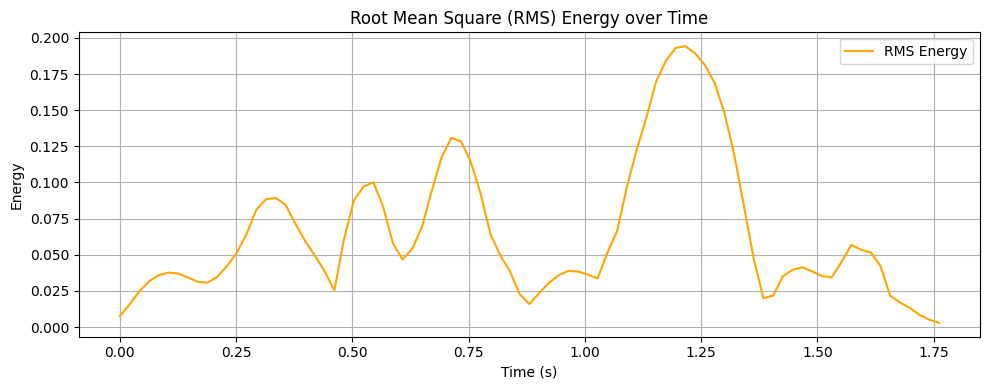

In [7]:
def extractNplot_energy(audio_file):
    """
    Extracts and visualizes the energy (RMS) of the audio signal.
    Calculates key statistics such as mean, standard deviation, min, and max energy.

    Args:
        audio_file (str): Path to the audio file.

    Returns:
        dict: A dictionary containing RMS statistics (mean, std, min, max).
    """
    # Calculate the Root Mean Square (RMS) energy
    rms = librosa.feature.rms(y=y)[0]  # RMS values (energy)

    # Generate time values corresponding to each RMS frame
    times = librosa.times_like(rms, sr=sr)

    # Calculate energy statistics
    rms_mean = np.mean(rms)
    rms_std = np.std(rms)
    rms_min = np.min(rms)
    rms_max = np.max(rms)

    # Print the statistics
    print(f"Energy (RMS):" + "\n" + f"Mean={rms_mean:.5f}" + "\n" + f"Std={rms_std:.5f}" + "\n" + f"Min={rms_min:.5f}" + "\n" + f"Max={rms_max:.5f}")

    # Visualization
    plt.figure(figsize=(10, 4))

    # Plot RMS Energy
    plt.plot(times, rms, label="RMS Energy", color="orange")
    plt.title("Root Mean Square (RMS) Energy over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "rms_mean": rms_mean,
        "rms_std": rms_std,
        "rms_min": rms_min,
        "rms_max": rms_max,
    }

audio_file = y, sr = original_df["audio_data"][1999], original_df["sr"][0]
energy_features = extractNplot_energy(audio_file)

### Extract Tempo Feature

Estimated Tempo: 150.58 BPM


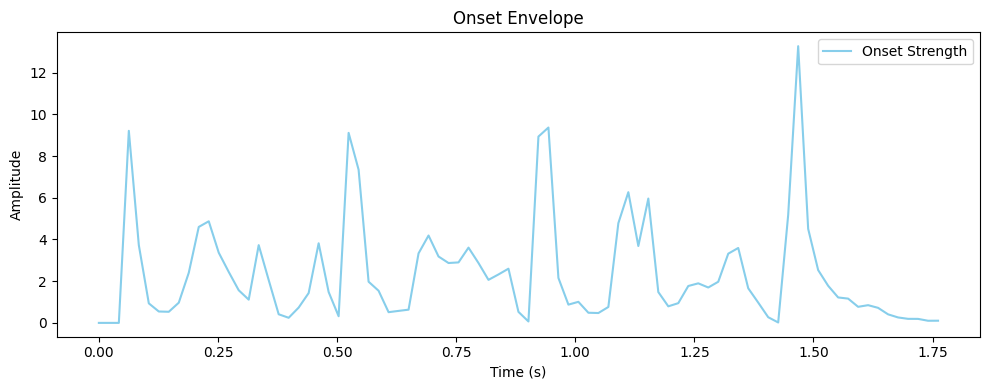

In [30]:
def extractNplot_tempo(audio_file):
    """
    Extracts and visualizes the tempo of the audio signal.
    Calculates the tempo using a pre-computed onset envelope.

    Args:
        audio_file (str): Path to the audio file.

    Returns:
        float: The estimated tempo in BPM.
    """
    # Calculate the onset envelope
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)

    # Estimate the tempo
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

    # Print the tempo
    print(f"Estimated Tempo: {tempo[0]:.2f} BPM")

    # Plot the onset envelope and tempo
    plt.figure(figsize=(10, 4))

    # Onset Envelope
    times = librosa.times_like(onset_env, sr=sr)
    plt.plot(times, onset_env, label='Onset Strength', color='skyblue')
    plt.title("Onset Envelope")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return tempo

audio_file = y, sr = original_df["audio_data"][1999], original_df["sr"][0]
tempo = extractNplot_tempo(audio_file)

# Spectral Features

### Extract MFCC (Mel-Frequency Cepstral Coefficients) Feature

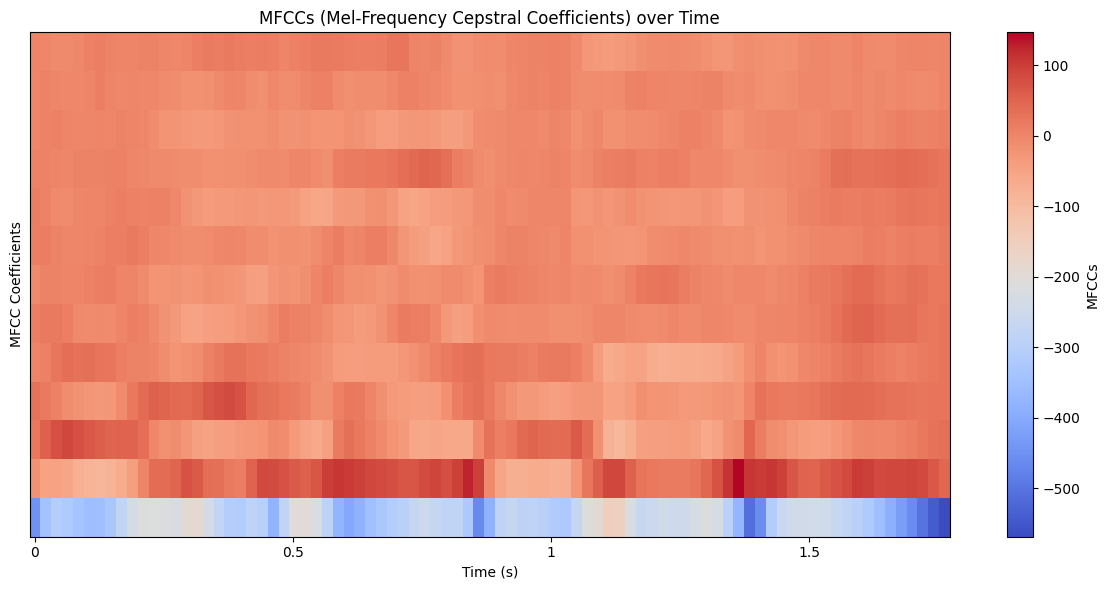


MFCC Statistics:
   MFCC Coefficient        Mean  Standard Deviation
0            MFCC 1 -301.264282           84.989738
1            MFCC 2   41.514183           61.056042
2            MFCC 3   -6.333564           41.650196
3            MFCC 4    5.712832           33.439079
4            MFCC 5   -4.891909           30.724756
5            MFCC 6   -2.671330           21.808407
6            MFCC 7   -0.440562           18.458406
7            MFCC 8   -6.286963           15.027778
8            MFCC 9  -13.083601           20.892790
9           MFCC 10    7.073929           17.196573
10          MFCC 11  -10.397070           13.618752
11          MFCC 12   -4.015265            7.356737
12          MFCC 13   -1.638986           13.500688


In [11]:
def extractNplot_mfcc(audio_file):
    """
    Extracts and visualizes the MFCCs (Mel-Frequency Cepstral Coefficients) of the audio signal.
    Calculates key statistics such as mean and standard deviation for each MFCC coefficient.

    Args:
        audio_file (str): Path to the audio file.

    Returns:
        dict: A dictionary containing the mean and standard deviation of each MFCC coefficient.
    """
    # Extract the first 13 MFCCs from the audio signal
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Calculate the mean and standard deviation of each MFCC coefficient
    mfccs_mean = np.mean(mfccs, axis=1)  # Mean of each MFCC coefficient
    mfccs_std = np.std(mfccs, axis=1)    # Standard deviation of each MFCC coefficient

    # Plot the MFCCs across time
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(mfccs, x_axis='time', sr=sr, cmap='coolwarm')
    plt.colorbar(label='MFCCs')
    plt.title("MFCCs (Mel-Frequency Cepstral Coefficients) over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC Coefficients")
    plt.tight_layout()
    plt.show()

    # Create a DataFrame to display the statistics for each MFCC coefficient
    mfcc_stats = pd.DataFrame({
        "MFCC Coefficient": [f"MFCC {i+1}" for i in range(13)],
        "Mean": mfccs_mean,
        "Standard Deviation": mfccs_std
    })

    # Display the MFCC statistics table
    print("\nMFCC Statistics:")
    print(mfcc_stats)

    return {
        "mfccs_mean": mfccs_mean,
        "mfccs_std": mfccs_std,
    }

audio_file = y, sr = original_df["audio_data"][1999], original_df["sr"][0]
mfcc_features = extractNplot_mfcc(audio_file)


### Extract Chroma Features

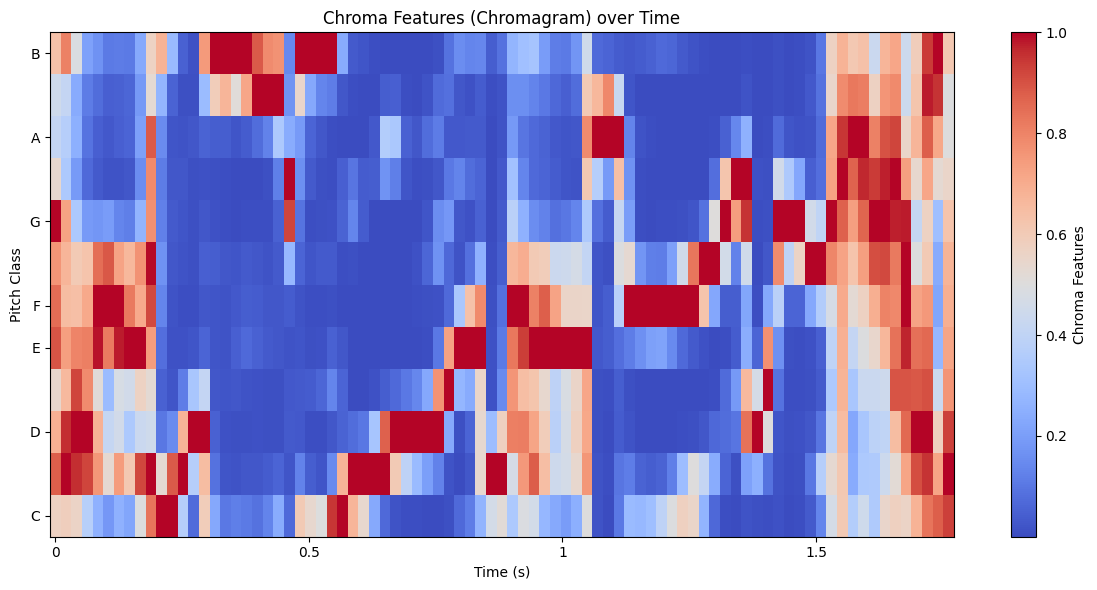


Chroma Features Statistics:
   Pitch Class      Mean  Standard Deviation
0      Pitch 1  0.336460            0.281496
1      Pitch 2  0.430781            0.356387
2      Pitch 3  0.388975            0.373356
3      Pitch 4  0.300229            0.311098
4      Pitch 5  0.367767            0.402395
5      Pitch 6  0.407750            0.386689
6      Pitch 7  0.374054            0.346524
7      Pitch 8  0.292451            0.356397
8      Pitch 9  0.244491            0.326422
9     Pitch 10  0.231831            0.325004
10    Pitch 11  0.257509            0.316125
11    Pitch 12  0.319990            0.350427


In [12]:
def extractNplot_chroma(audio_file):
    """
    Extracts and visualizes the Chroma Features (chromagram) of the audio signal.
    Calculates key statistics such as mean and standard deviation for each pitch class.

    Args:
        audio_file (str): Path to the audio file.

    Returns:
        dict: A dictionary containing the mean and standard deviation of each Chroma feature.
    """
    # Extract the Chroma Features (chromagram) from the audio signal
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)

    # Calculate the mean and standard deviation for each pitch class (12 bins)
    chroma_mean = np.mean(chroma, axis=1)  # Mean of each chroma feature (pitch class)
    chroma_std = np.std(chroma, axis=1)    # Standard deviation of each chroma feature (pitch class)

    # Plot the Chroma Features across time
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', sr=sr, cmap='coolwarm')
    plt.colorbar(label='Chroma Features')
    plt.title("Chroma Features (Chromagram) over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Pitch Class")
    plt.tight_layout()
    plt.show()

    # Create a DataFrame to display the statistics for each Chroma feature (pitch class)
    chroma_stats = pd.DataFrame({
        "Pitch Class": [f"Pitch {i+1}" for i in range(12)],
        "Mean": chroma_mean,
        "Standard Deviation": chroma_std
    })

    # Display the Chroma statistics table
    print("\nChroma Features Statistics:")
    print(chroma_stats)

    return {
        "chroma_mean": chroma_mean,
        "chroma_std": chroma_std,
    }
    
audio_file = y, sr = original_df["audio_data"][1999], original_df["sr"][0]
chroma_features = extractNplot_chroma(audio_file)


### Extract Spectral Centroid

Spectral Centroid: Mean=3475.86, Std=2850.66


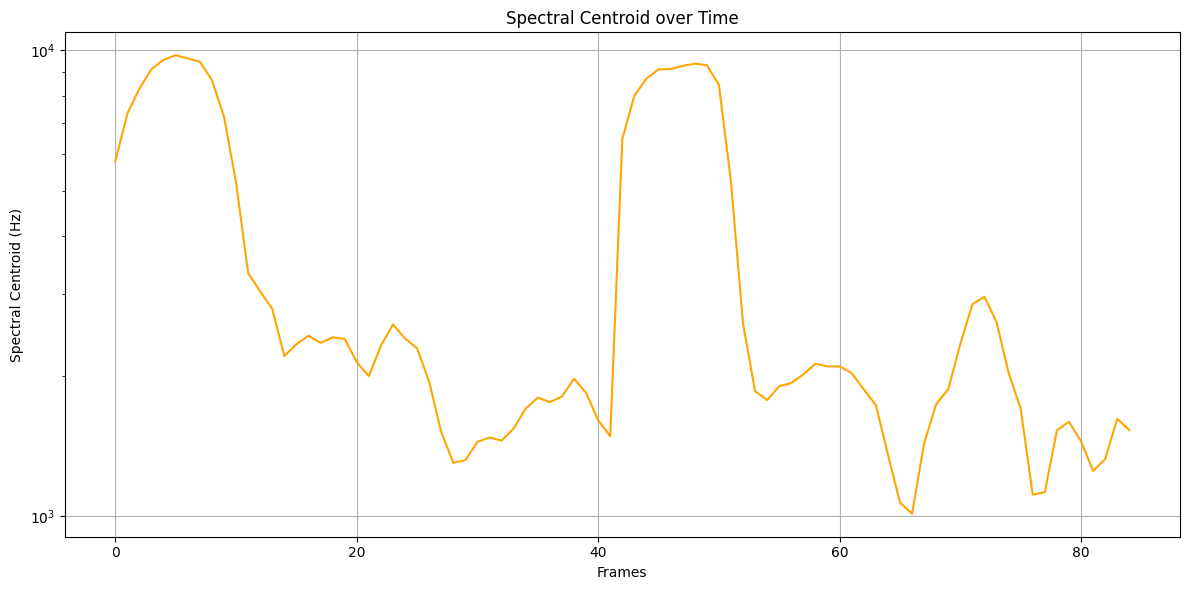

In [13]:
def extractNplot_spectral_centroid(audio_file):
    """
    Extracts and visualizes the Spectral Centroid of the audio signal.
    Calculates key statistics such as mean and standard deviation.

    Args:
        audio_file (str): Path to the audio file.

    Returns:
        dict: A dictionary containing the mean and standard deviation of the Spectral Centroid.
    """
    # Extract the Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

    # Calculate the mean and standard deviation of the Spectral Centroid
    centroid_mean = np.mean(spectral_centroid)
    centroid_std = np.std(spectral_centroid)

    # Print the statistics
    print(f"Spectral Centroid: Mean={centroid_mean:.2f}, Std={centroid_std:.2f}")

    # Plot the Spectral Centroid across time
    plt.figure(figsize=(12, 6))
    plt.semilogy(spectral_centroid, label='Spectral Centroid', color='orange')
    plt.ylabel('Spectral Centroid (Hz)')
    plt.xlabel('Frames')
    plt.title("Spectral Centroid over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return the statistics in a dictionary
    return {
        "centroid_mean": centroid_mean,
        "centroid_std": centroid_std,
    }

audio_file = y, sr = original_df["audio_data"][1999], original_df["sr"][0]
spectral_centroid_stats = extractNplot_spectral_centroid(audio_file)


### Extract Spectral Bandwith

Spectral Bandwidth: Mean=2410.22, Std=458.20


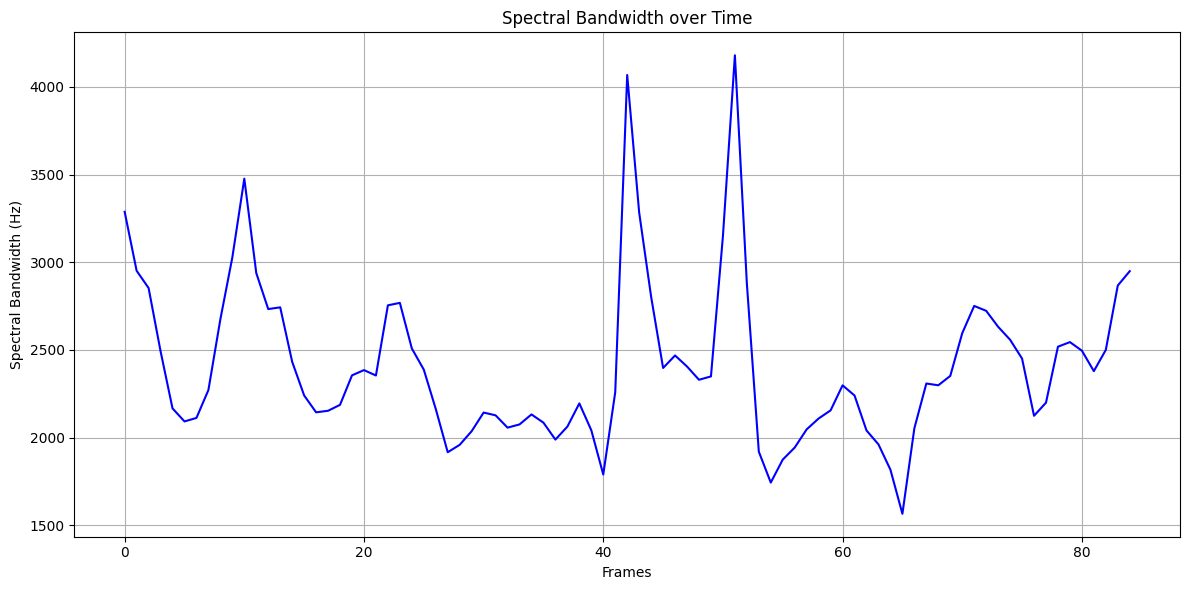

In [14]:
def extractNplot_spectral_bandwidth(audio_file):
    """
    Extracts and visualizes the Spectral Bandwidth of the audio signal.
    Calculates key statistics such as mean and standard deviation.

    Args:
        audio_file (str): Path to the audio file.

    Returns:
        dict: A dictionary containing the mean and standard deviation of the Spectral Bandwidth.
    """
    # Extract the Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]

    # Calculate the mean and standard deviation of the Spectral Bandwidth
    bandwidth_mean = np.mean(spectral_bandwidth)
    bandwidth_std = np.std(spectral_bandwidth)

    # Print the statistics
    print(f"Spectral Bandwidth: Mean={bandwidth_mean:.2f}, Std={bandwidth_std:.2f}")

    # Plot the Spectral Bandwidth across time
    plt.figure(figsize=(12, 6))
    plt.plot(spectral_bandwidth, label='Spectral Bandwidth', color='blue')
    plt.ylabel('Spectral Bandwidth (Hz)')
    plt.xlabel('Frames')
    plt.title("Spectral Bandwidth over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return the statistics in a dictionary
    return {
        "bandwidth_mean": bandwidth_mean,
        "bandwidth_std": bandwidth_std,
    }

audio_file = y, sr = original_df["audio_data"][1999], original_df["sr"][0]
spectral_bandwidth_stats = extractNplot_spectral_bandwidth(audio_file)


### Extract Spectral Flux

Spectral Flux: Mean=2.37, Std=2.52


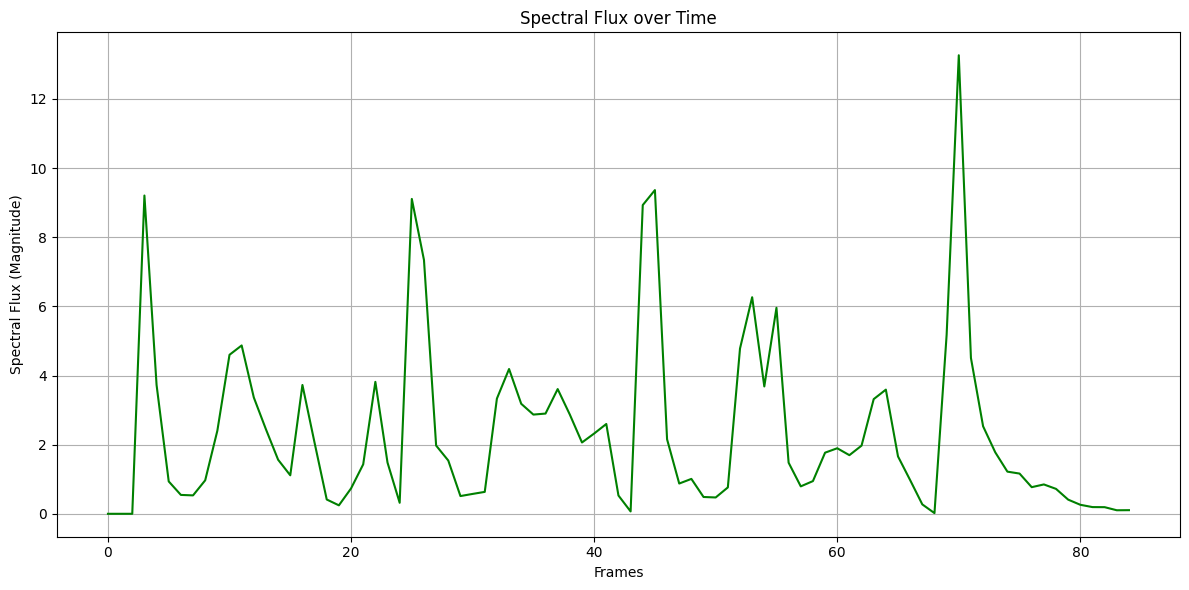

In [15]:
def extractNplot_spectral_flux(audio_file):
    """
    Extracts and visualizes the Spectral Flux of the audio signal.
    Calculates key statistics such as mean and standard deviation.

    Args:
        audio_file (str): Path to the audio file.

    Returns:
        dict: A dictionary containing the mean and standard deviation of the Spectral Flux.
    """
    # Extract the onset strength (spectral flux) from the audio signal
    spectral_flux = librosa.onset.onset_strength(y=y, sr=sr)

    # Calculate the mean and standard deviation of the Spectral Flux
    flux_mean = np.mean(spectral_flux)
    flux_std = np.std(spectral_flux)

    # Print the statistics
    print(f"Spectral Flux: Mean={flux_mean:.2f}, Std={flux_std:.2f}")

    # Plot the Spectral Flux across time
    plt.figure(figsize=(12, 6))
    plt.plot(spectral_flux, label='Spectral Flux', color='green')
    plt.ylabel('Spectral Flux (Magnitude)')
    plt.xlabel('Frames')
    plt.title("Spectral Flux over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return the statistics in a dictionary
    return {
        "flux_mean": flux_mean,
        "flux_std": flux_std,
    }

audio_file = y, sr = original_df["audio_data"][1999], original_df["sr"][0]
spectral_flux_stats = extractNplot_spectral_flux(audio_file)

### **Building Features Dataframe**

### **Feature Extraction Functions**

#### **Prosodic Features**

In [16]:
def extract_pitch(audio_data, sr):
    pitches, magnitudes = librosa.piptrack(y=audio_data, sr=sr)
    pitch = [p[m.argmax()] for p, m in zip(pitches, magnitudes) if m.max() > 0]

    if pitch:
        pitch_mean = np.mean(pitch)
        pitch_std = np.std(pitch)
    else:
        pitch_mean = np.nan
        pitch_std = np.nan

    return np.array([pitch_mean, pitch_std])


def extract_energy(audio_data):
    rms = librosa.feature.rms(y=audio_data)[0]
    energy_mean = np.mean(rms)
    energy_std = np.std(rms)
    return np.array([energy_mean, energy_std])

def extract_tempo(audio_data, sr):
    tempo, _ = librosa.beat.beat_track(y=audio_data, sr=sr)
    return np.array([tempo])

#### **Spectral Features**

In [17]:
def extract_mfcc(audio_data, sr, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    return np.concatenate([mfccs_mean, mfccs_std])


def extract_chroma(audio_data, sr):
    chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    chroma_std = np.std(chroma, axis=1)
    return np.concatenate([chroma_mean, chroma_std])


def extract_spectral_centroid(audio_data, sr):
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sr)
    spectral_centroid_mean = np.mean(spectral_centroid)
    spectral_centroid_std = np.std(spectral_centroid)
    return np.array([spectral_centroid_mean, spectral_centroid_std])


def extract_spectral_bandwidth(audio_data, sr):
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)
    spectral_bandwidth_std = np.std(spectral_bandwidth)
    return np.array([spectral_bandwidth_mean, spectral_bandwidth_std])


def extract_spectral_flux(audio_data, sr):
    spectral_flux = np.mean(
        np.diff(librosa.feature.spectral_centroid(y=audio_data, sr=sr), axis=1)
    )
    return np.array([spectral_flux])

In [18]:
def extract_features_combined(y, sr):
    features = {}

    # Prosodic Features
    # Extract and aggregate Pitch
    pitch = extract_pitch(y, sr)
    features["pitch_mean"] = pitch[0]
    features["pitch_std"] = pitch[1]

    # Extract and aggregate Energy
    energy = extract_energy(y)
    features["energy_mean"] = energy[0]
    features["energy_std"] = energy[1]
    
    # Extract Tempo
    tempo = extract_tempo(y, sr)
    features["tempo"] = tempo[0]

    # Spectral Features
    # Extract and aggregate MFCCs
    mfccs = extract_mfcc(y, sr)
    for i in range(1, 14):
        features[f"mfcc_{i}_mean"] = mfccs[i - 1]
    for i in range(14, 27):
        features[f"mfcc_{i-13}_std"] = mfccs[i - 1]

    # Extract and aggregate Chroma
    chroma = extract_chroma(y, sr)
    for i in range(1, 13):
        features[f"chroma_{i}_mean"] = chroma[i - 1]
    for i in range(13, 25):
        features[f"chroma_{i-12}_std"] = chroma[i - 1]

    # Extract and aggregate Spectral Centroid
    spectral_centroid = extract_spectral_centroid(y, sr)
    features["spectral_centroid_mean"] = spectral_centroid[0]
    features["spectral_centroid_std"] = spectral_centroid[1]

    # Extract and aggregate Spectral Bandwidth
    spectral_bandwidth = extract_spectral_bandwidth(y, sr)
    features["spectral_bandwidth_mean"] = spectral_bandwidth[0]
    features["spectral_bandwidth_std"] = spectral_bandwidth[1]

    # Extract Spectral Flux
    spectral_flux = extract_spectral_flux(y, sr)
    features["spectral_flux"] = spectral_flux[0]

    return features


def create_feature_dataframe(df, audio_column, sr_column):
    """
    Extract features from audio data and create a feature dataframe.

    Parameters:
    - df (pd.DataFrame): DataFrame containing audio data.
    - audio_column (str): Name of the column with audio time series.
    - sr_column (str): Name of the column with sampling rates.

    Returns:
    - pd.DataFrame: DataFrame with extracted features.
    """
    feature_list = []

    for index in tqdm(df.index, desc="Extracting Features"):
        y = df.at[index, audio_column]
        sr = df.at[index, sr_column]

        # Ensure audio data is valid
        if isinstance(y, (np.ndarray, list)) and len(y) > 0:
            features = extract_features_combined(y, sr)
        else:
            # Handle invalid data by setting features to NaN
            features = {
                **{f"mfcc_{i}_mean": np.nan for i in range(1, 14)},
                **{f"mfcc_{i}_std": np.nan for i in range(1, 14)},
                **{f"chroma_{i}_mean": np.nan for i in range(1, 13)},
                **{f"chroma_{i}_std": np.nan for i in range(1, 13)},
                "spectral_centroid_mean": np.nan,
                "spectral_centroid_std": np.nan,
                "spectral_bandwidth_mean": np.nan,
                "spectral_bandwidth_std": np.nan,
                "spectral_flux": np.nan,
                "pitch_mean": np.nan,
                "pitch_std": np.nan,
                "energy_mean": np.nan,
                "energy_std": np.nan,
            }

        feature_list.append(features)

    features_df = pd.DataFrame(feature_list)
    return features_df

In [19]:
features_df = create_feature_dataframe(original_df, "audio_data", "sr")
features_df.shape

Extracting Features: 100%|██████████| 2800/2800 [03:13<00:00, 14.48it/s]


(2800, 60)

In [20]:
# add the extracted features to the original dataframe
df = pd.concat([original_df, features_df], axis=1)
df.head()

,filename,emotion,audio_data,sr,pitch_mean,pitch_std,energy_mean,energy_std,tempo,mfcc_1_mean,...,chroma_8_std,chroma_9_std,chroma_10_std,chroma_11_std,chroma_12_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_flux
0,YAF_date_disgust.wav,disgust,"[9.1552734e-05, 0.00018310547, 9.1552734e-05, ...",24414,2071.459229,1122.231567,0.016092,0.013045,[98.65571120689656],-434.324219,...,0.347993,0.309924,0.315045,0.341044,0.327843,3432.969559,2246.896031,2373.858313,635.292965,-13.403248
1,YAF_rag_disgust.wav,disgust,"[0.0, 0.00015258789, 0.0, 0.0, -3.0517578e-05,...",24414,1965.404297,1069.445190,0.023437,0.017247,[98.65571120689656],-389.423798,...,0.303675,0.341516,0.325265,0.358694,0.330496,2980.574046,2394.357512,2268.882560,701.641062,-10.853234
2,YAF_raise_disgust.wav,disgust,"[6.1035156e-05, 0.0, 6.1035156e-05, 0.00024414...",24414,1950.519043,1099.693726,0.022233,0.017019,[168.29503676470588],-413.006409,...,0.329638,0.295243,0.340599,0.326995,0.299150,3544.674271,2958.180836,2277.562156,649.071798,-19.051806
3,YAF_ditch_disgust.wav,disgust,"[0.00021362305, 0.00045776367, 0.00021362305, ...",24414,2104.329102,1123.325928,0.015660,0.012907,[102.17912946428571],-436.991699,...,0.335150,0.298914,0.322297,0.301237,0.337893,3473.697956,2234.339988,2358.844339,694.640628,-7.595847
4,YAF_door_disgust.wav,disgust,"[-0.00024414062, -0.00039672852, -6.1035156e-0...",24414,1773.012085,1101.566284,0.027582,0.025722,[73.359375],-414.527679,...,0.326570,0.342577,0.306411,0.333062,0.339389,2928.849458,2591.185463,2264.684970,830.706995,-19.630475


In [21]:
def run_knn_classification(X_train, X_test, y_train, y_test):
    # Initialize the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=5)

    # Train the model
    knn.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = knn.predict(X_test)

    print("------------------- K-Nearest Neighbors -------------------\n")

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Generate a classification report
    class_report = classification_report(y_test, y_pred)

    print("Classification Report:")
    print(class_report)


def run_random_forest_classification(X_train, X_test, y_train, y_test):
    # Initialize the RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, random_state=99)

    # Train the model
    rf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf.predict(X_test)

    print("------------------- Random Forest -------------------\n")

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Generate a classification report
    class_report = classification_report(y_test, y_pred)

    print("Classification Report:")
    print(class_report)

In [22]:
# Split the data into features and labels
X = df.drop(columns=["filename", "emotion", "audio_data", "sr"])
y = df["emotion"]

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets using the 70-30 holdout method
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=99,
)

In [23]:
run_knn_classification(X_train, X_test, y_train, y_test)

------------------- K-Nearest Neighbors -------------------

Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00       114
     disgust       0.97      0.95      0.96       123
        fear       1.00      0.97      0.99       118
       happy       0.92      0.99      0.96       129
     neutral       1.00      1.00      1.00       120
         sad       1.00      1.00      1.00       118
   surprised       0.96      0.92      0.94       118

    accuracy                           0.98       840
   macro avg       0.98      0.98      0.98       840
weighted avg       0.98      0.98      0.98       840



In [24]:
run_random_forest_classification(X_train, X_test, y_train, y_test)

------------------- Random Forest -------------------

Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00       114
     disgust       0.98      1.00      0.99       123
        fear       0.99      0.99      0.99       118
       happy       0.97      0.99      0.98       129
     neutral       1.00      1.00      1.00       120
         sad       1.00      1.00      1.00       118
   surprised       0.99      0.95      0.97       118

    accuracy                           0.99       840
   macro avg       0.99      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840



In [25]:
def feature_group_importance_knn(X, y, feature_groups, n_neighbors=5, cv=5):
    # Initialize the KNN classifier
    baseline_model = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Calculate baseline accuracy with all features
    baseline_scores = cross_val_score(baseline_model, X, y, cv=cv)
    baseline_accuracy = baseline_scores.mean()

    group_importance = {}

    # Iterate over each feature group
    for group_name, group_features in feature_groups.items():
        # Check if all group_features are in X
        missing_features = set(group_features) - set(X.columns)
        if missing_features:
            print(
                f"Warning: The following features are not in the dataset and will be skipped: {missing_features}"
            )
            group_features = list(set(group_features) - missing_features)
            if not group_features:
                print(
                    f"Skipping group '{group_name}' as no valid features are present."
                )
                continue

        # Remove the group features
        X_reduced = X.drop(columns=group_features)

        # Initialize and train the classifier
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
        scores = cross_val_score(model, X_reduced, y, cv=cv)
        accuracy = scores.mean()

        # Calculate the decrease in accuracy
        importance = baseline_accuracy - accuracy
        group_importance[group_name] = importance

    # Create a DataFrame for the results
    importance_df = pd.DataFrame(
        {
            "Feature Group": list(group_importance.keys()),
            "Accuracy Decrease": list(group_importance.values()),
        }
    )

    # Sort the DataFrame by accuracy decrease in descending order
    importance_df = importance_df.sort_values(
        by="Accuracy Decrease", ascending=False
    ).reset_index(drop=True)

    return importance_df

In [26]:
# Define feature groups based on feature name prefixes
feature_groups = {
    "MFCC": [feature for feature in features_df.columns if feature.startswith("mfcc")],
    "Chroma": [
        feature for feature in features_df.columns if feature.startswith("chroma")
    ],
    "Spectral Centroid": [
        feature
        for feature in features_df.columns
        if feature.startswith("spectral_centroid")
    ],
    "Spectral Bandwidth": [
        feature
        for feature in features_df.columns
        if feature.startswith("spectral_bandwidth")
    ],
    "Spectral Flux": [
        feature
        for feature in features_df.columns
        if feature.startswith("spectral_flux")
    ],
    "Pitch": [
        feature for feature in features_df.columns if feature.startswith("pitch")
    ],
    "Energy": [
        feature for feature in features_df.columns if feature.startswith("energy")
    ],
    "Tempo": ["tempo"],
}

In [27]:
X_scaled = pd.DataFrame(X, columns=features_df.columns)

importance_results = feature_group_importance_knn(
    X_scaled, y, feature_groups, n_neighbors=5, cv=5
)

importance_results

,Feature Group,Accuracy Decrease
0,MFCC,0.131071
1,Chroma,0.010357
2,Spectral Bandwidth,0.004643
3,Spectral Flux,0.000357
4,Pitch,0.000000
5,Energy,-0.000357
6,Spectral Centroid,-0.001429
7,Tempo,-0.002143


Silhouette Score: 0.1496


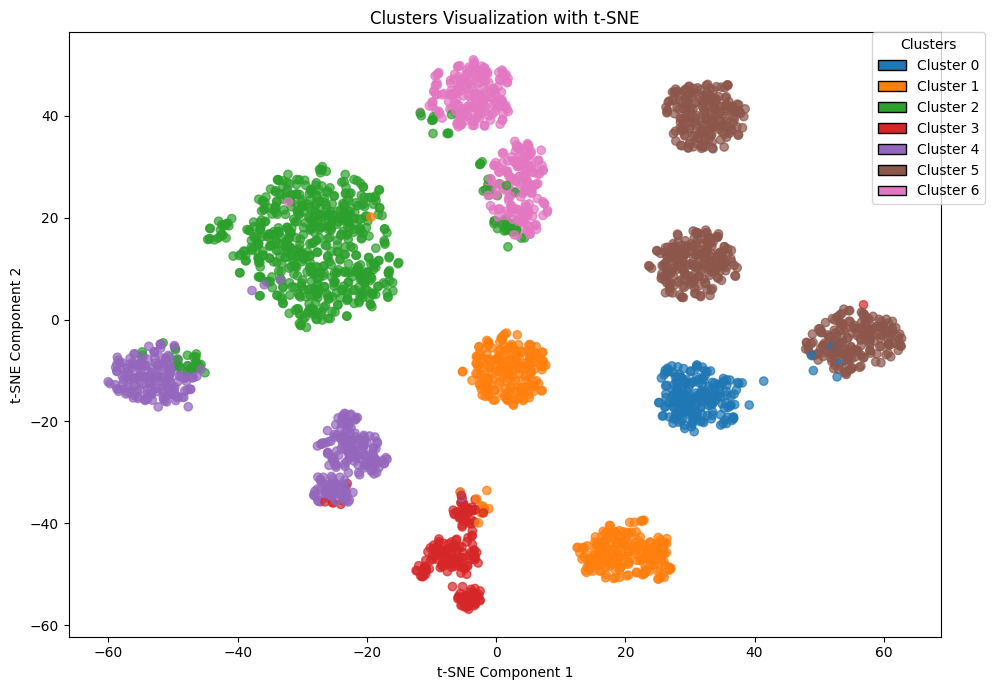

In [28]:
# Drop the 'emotion' column for clustering purposes
data = df.drop(columns=["filename", "emotion", "audio_data", "sr"])

# Handle any missing values if necessary
data = data.fillna(0)

# Standardize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply KMeans clustering algorithm
kmeans = KMeans(n_clusters=n_emotions, random_state=99)
kmeans.fit(data_scaled)

# Get the cluster labels
labels = kmeans.labels_

# Evaluate the clustering results using silhouette score
silhouette_avg = silhouette_score(data_scaled, labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Reduce the data to two dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=99)
data_tsne = tsne.fit_transform(data_scaled)

cmap = ListedColormap(plt.get_cmap("tab10").colors[:n_emotions])

# Create the scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    data_tsne[:, 0], data_tsne[:, 1], c=labels, cmap=cmap, marker="o", alpha=0.7
)
plt.title("Clusters Visualization with t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Create custom legend
# Generate a list of unique cluster labels
unique_labels = np.unique(labels)

# Create a list of Patch objects for the legend
legend_elements = [
    Patch(facecolor=cmap(i), edgecolor="k", label=f"Cluster {i}") for i in unique_labels
]

# Add the legend to the plot
plt.legend(
    handles=legend_elements,
    title="Clusters",
    loc="best",
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()